In [1]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
import math
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline

/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


## Group comparison

In [2]:
dates_list = ['2408', '2708', '2908','0309', '0609']
#dates_list = [ '2408', '2708']#'0609']
#dates_list = [ '0309', '0609']
#exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']
exps = ['AER', 'AEUR', 'RAND','AENR10', 'AENUR10', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']
#exps = ['AER','AENR10', 'AENUR10']

exp_data = dict()

for date in dates_list:
    exp_data.update({date:{'AER': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AER/log/log.log',
                                   'label': 'Rotated',
                                    'plot':['#fa8174', '-']},
        'AEUR': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AEUR/log/log.log',
                 'label': 'Unrotated',
                 'plot': ['c','--']},
        'RAND':{'log': '/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/RAND/log/log.log',
                'label': 'Random',
                 'plot':['r', '-.'] },
        'AENR10':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE10NR/log/log.log',
                  'label': 'Noisy 10 Rotated',
                 'plot':['m','-']},
        'AENUR10': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE10NUR/log/log.log',
                    'label': 'Noisy 10 Unrotated',
                 'plot':['g','--']},
        'AENR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE25NR/log/log.log',
                  'label': 'Noisy 25 Rotated',
                 'plot':['k','-']},
        'AENUR25': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE25NUR/log/log.log',
                    'label': 'Noisy 25 Unrotated',
                 'plot':['b','--']},
        'AENR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE50NR/log/log.log',
                  'label': 'Noisy 50 Rotated',
                 'plot':['y','-']},
        'AENUR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/MLP/AE50NUR/log/log.log',
                   'label': 'Noisy 50 Unrotated',
                 'plot':['#8A2BE2','--']},
            }
        })
    
    for exp in exps:
        e = LearningCurve(exp_data[date][exp]['log'])
        e.parse()
        for phase in [Phase.TRAIN, Phase.TEST]:
            exp_data[date][exp][phase] = {}
            exp_data[date][exp][phase]['num_iter'] = e.list('NumIters', phase)
            exp_data[date][exp][phase]['loss'] = e.list('loss', phase)
            exp_data[date][exp][phase]['acc'] = e.list('accuracy', phase)
            
        

In [3]:
#Extract Test accuracy and Trains loss over groups
acc = [[] for e in exps]
loss = [[] for e in exps]

for d,_ in exp_data.items():
    for i,e in enumerate(exps):
        acc[i].append(exp_data[d][e][Phase.TEST]['acc'])
        loss[i].append(exp_data[d][e][Phase.TRAIN]['loss'])
        
    
    
    


(0, 'AER')
(1, 'AEUR')
(2, 'RAND')
(3, 'AENR10')
(4, 'AENUR10')
(5, 'AENR25')
(6, 'AENUR25')
(7, 'AENR50')
(8, 'AENUR50')


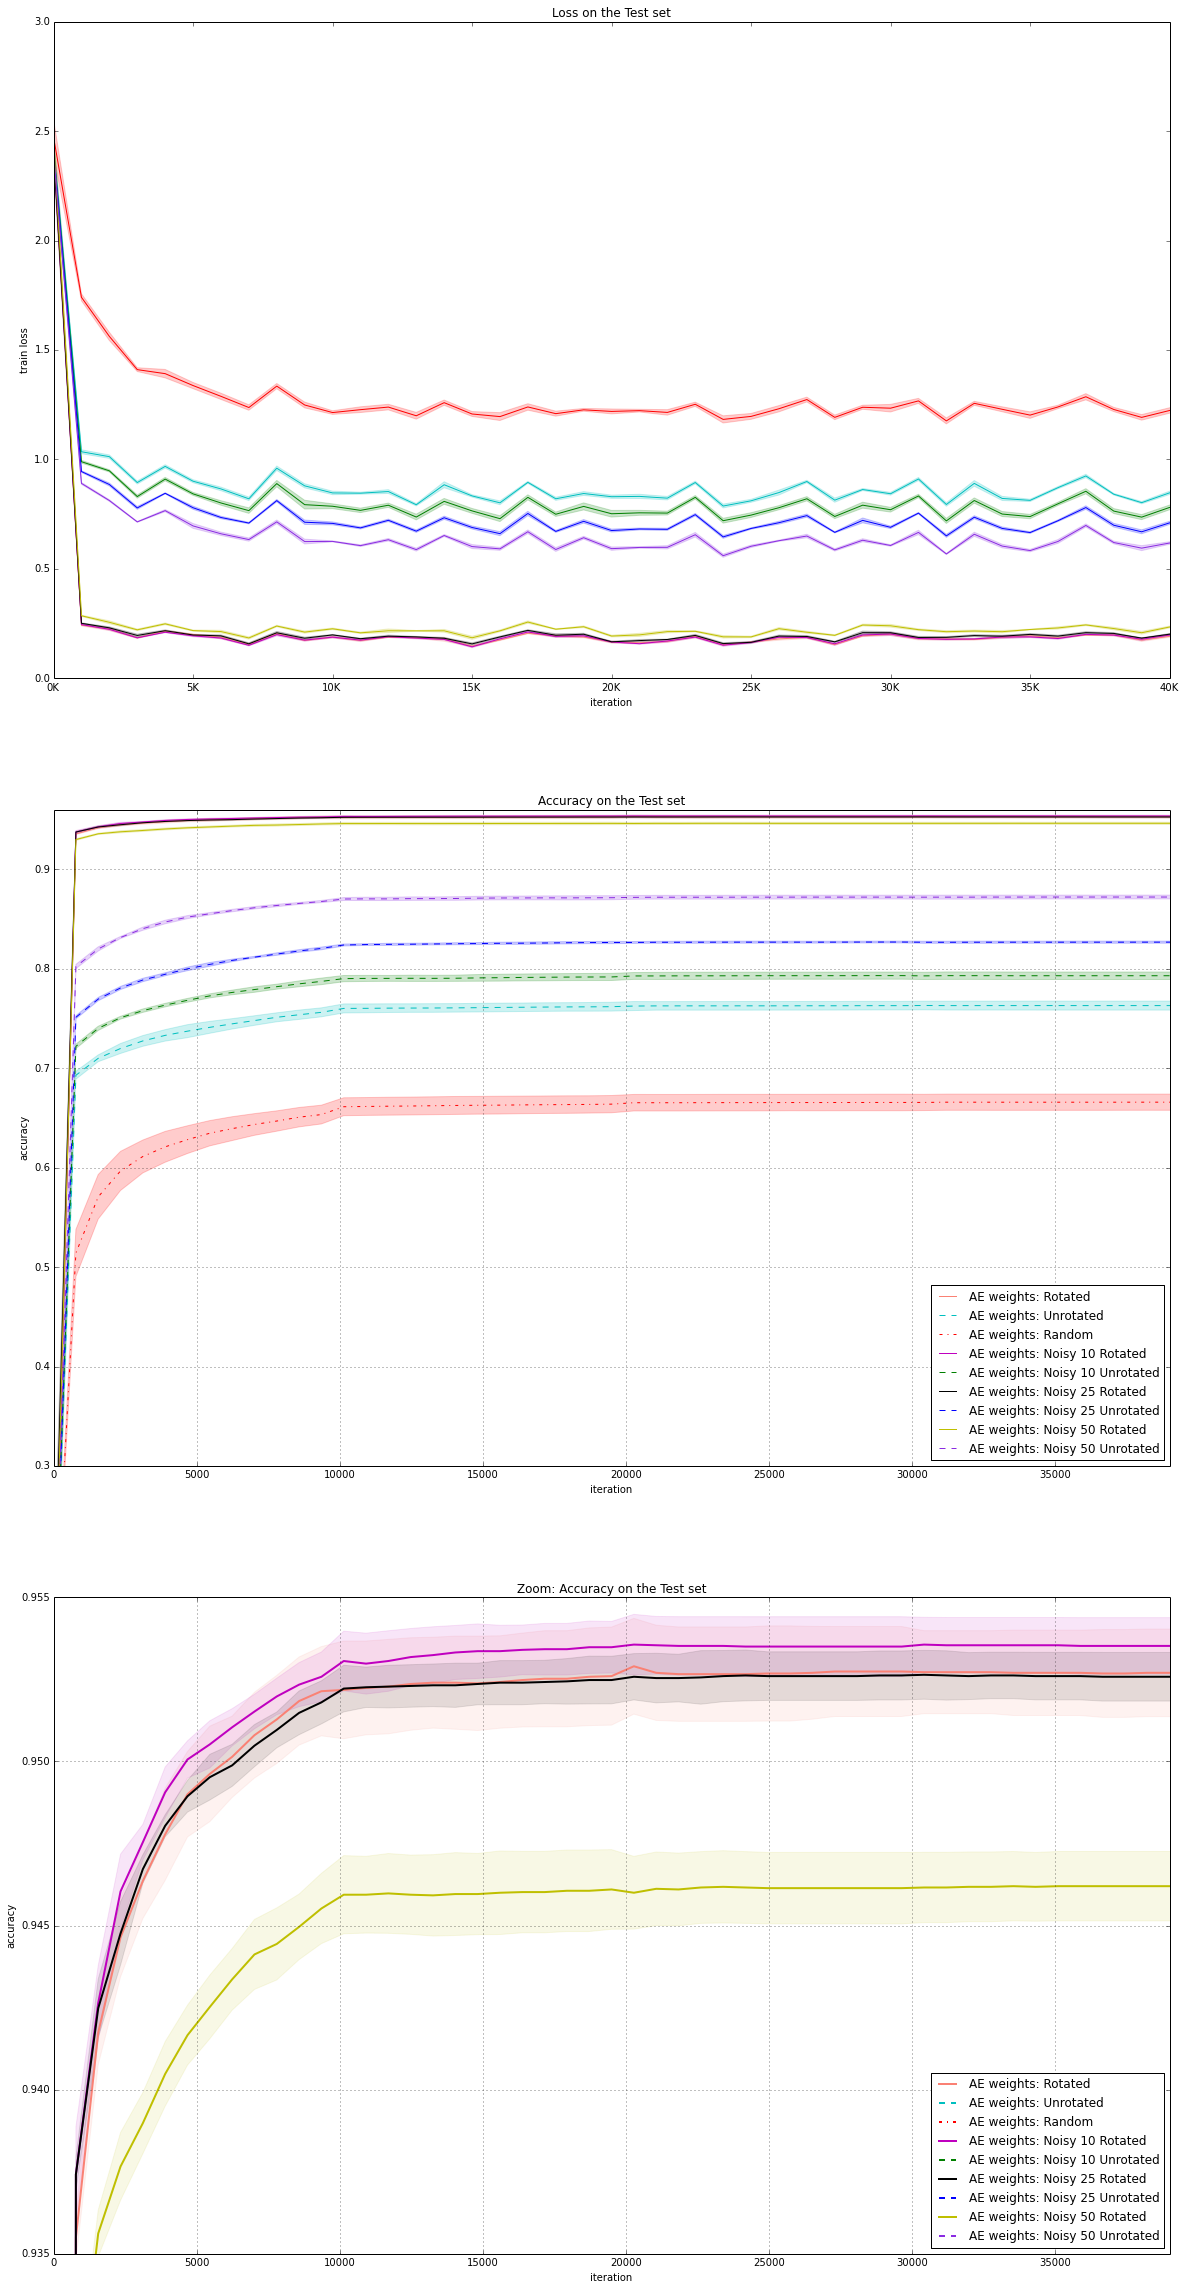

In [25]:
#exp_labels = ['Rotated', 'Unrotated', 'Random', '25 Rotated', '25 Unrotated', '50 Rotated' , '50 Unrotated']
#exp_labels = ['Rotated', 'Unrotated', 'Random', '10 Rotated', '10 Unrotated', '25 Rotated', '25 Unrotated', '50 Rotated' , '50 Unrotated']

#exps = ['AER','AENR10', 'AENUR10', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']
#exp_labels = ['Rotated', '10 Rotated', '10 Unrotated', '25 Rotated', '25 Unrotated', '50 Rotated', '50 Unrotated']


#exps = ['AER','AENUR10','AENR25', 'AENR50']



fig = plt.figure(figsize=(20,40))
xmax = 39000
ymin = 0.7
ymax = 0.96
fix_date = dates_list[0]
num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
for i,e in enumerate(exps):
    print(i,e)

    
    
    plt.subplot(3,1,1)
    ma = np.mean(loss[i], axis = 0).squeeze()
    mstd = np.std(loss[i], axis = 0).squeeze()
    num_iter = exp_data[fix_date]['AER'][Phase.TRAIN]['num_iter']
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=exp_data[fix_date][e]['plot'][0])
    plt.fill_between(num_iter.squeeze(), ma-1*mstd, ma+1*mstd,  color=exp_data[fix_date][e]['plot'][0], alpha=0.2)
    plt.xlim(0,xmax)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train loss')
    plt.title("Loss on the %s set" % (phase,))
    
    
    ymin = 0.3
    ymax = 0.96
    plt.subplot(3,1,2)
    num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
    ma = np.mean(acc[i], axis = 0).squeeze()
    mstd = np.std(acc[i], axis = 0).squeeze()
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_data[fix_date][e]['label'],),  color=exp_data[fix_date][e]['plot'][0], linestyle = exp_data[fix_date][e]['plot'][1])
    plt.fill_between(num_iter.squeeze(), ma-1*mstd, ma+1*mstd,  color=exp_data[fix_date][e]['plot'][0], alpha=0.2)
    plt.xlim(0,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title("Accuracy on the %s set" % (phase,))
    plt.legend(loc='lower right')
    plt.grid()

    
    ymin = 0.935
    ymax = 0.955
    plt.subplot(3,1,3)
    num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
    ma = np.mean(acc[i], axis = 0).squeeze()
    mstd = np.std(acc[i], axis = 0).squeeze()
    plt.plot(num_iter, ma, label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=exp_data[fix_date][e]['plot'][0], linestyle = exp_data[fix_date][e]['plot'][1],linewidth=2)
    plt.fill_between(num_iter.squeeze(), ma-1*mstd, ma+1*mstd, color=exp_data[fix_date][e]['plot'][0], alpha=0.1)
    plt.xlim(0,xmax)
    plt.ylim(ymin,ymax)
    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title("Zoom: Accuracy on the %s set" % (phase,))
    plt.legend(loc='lower right')
    plt.grid()

plt.show()

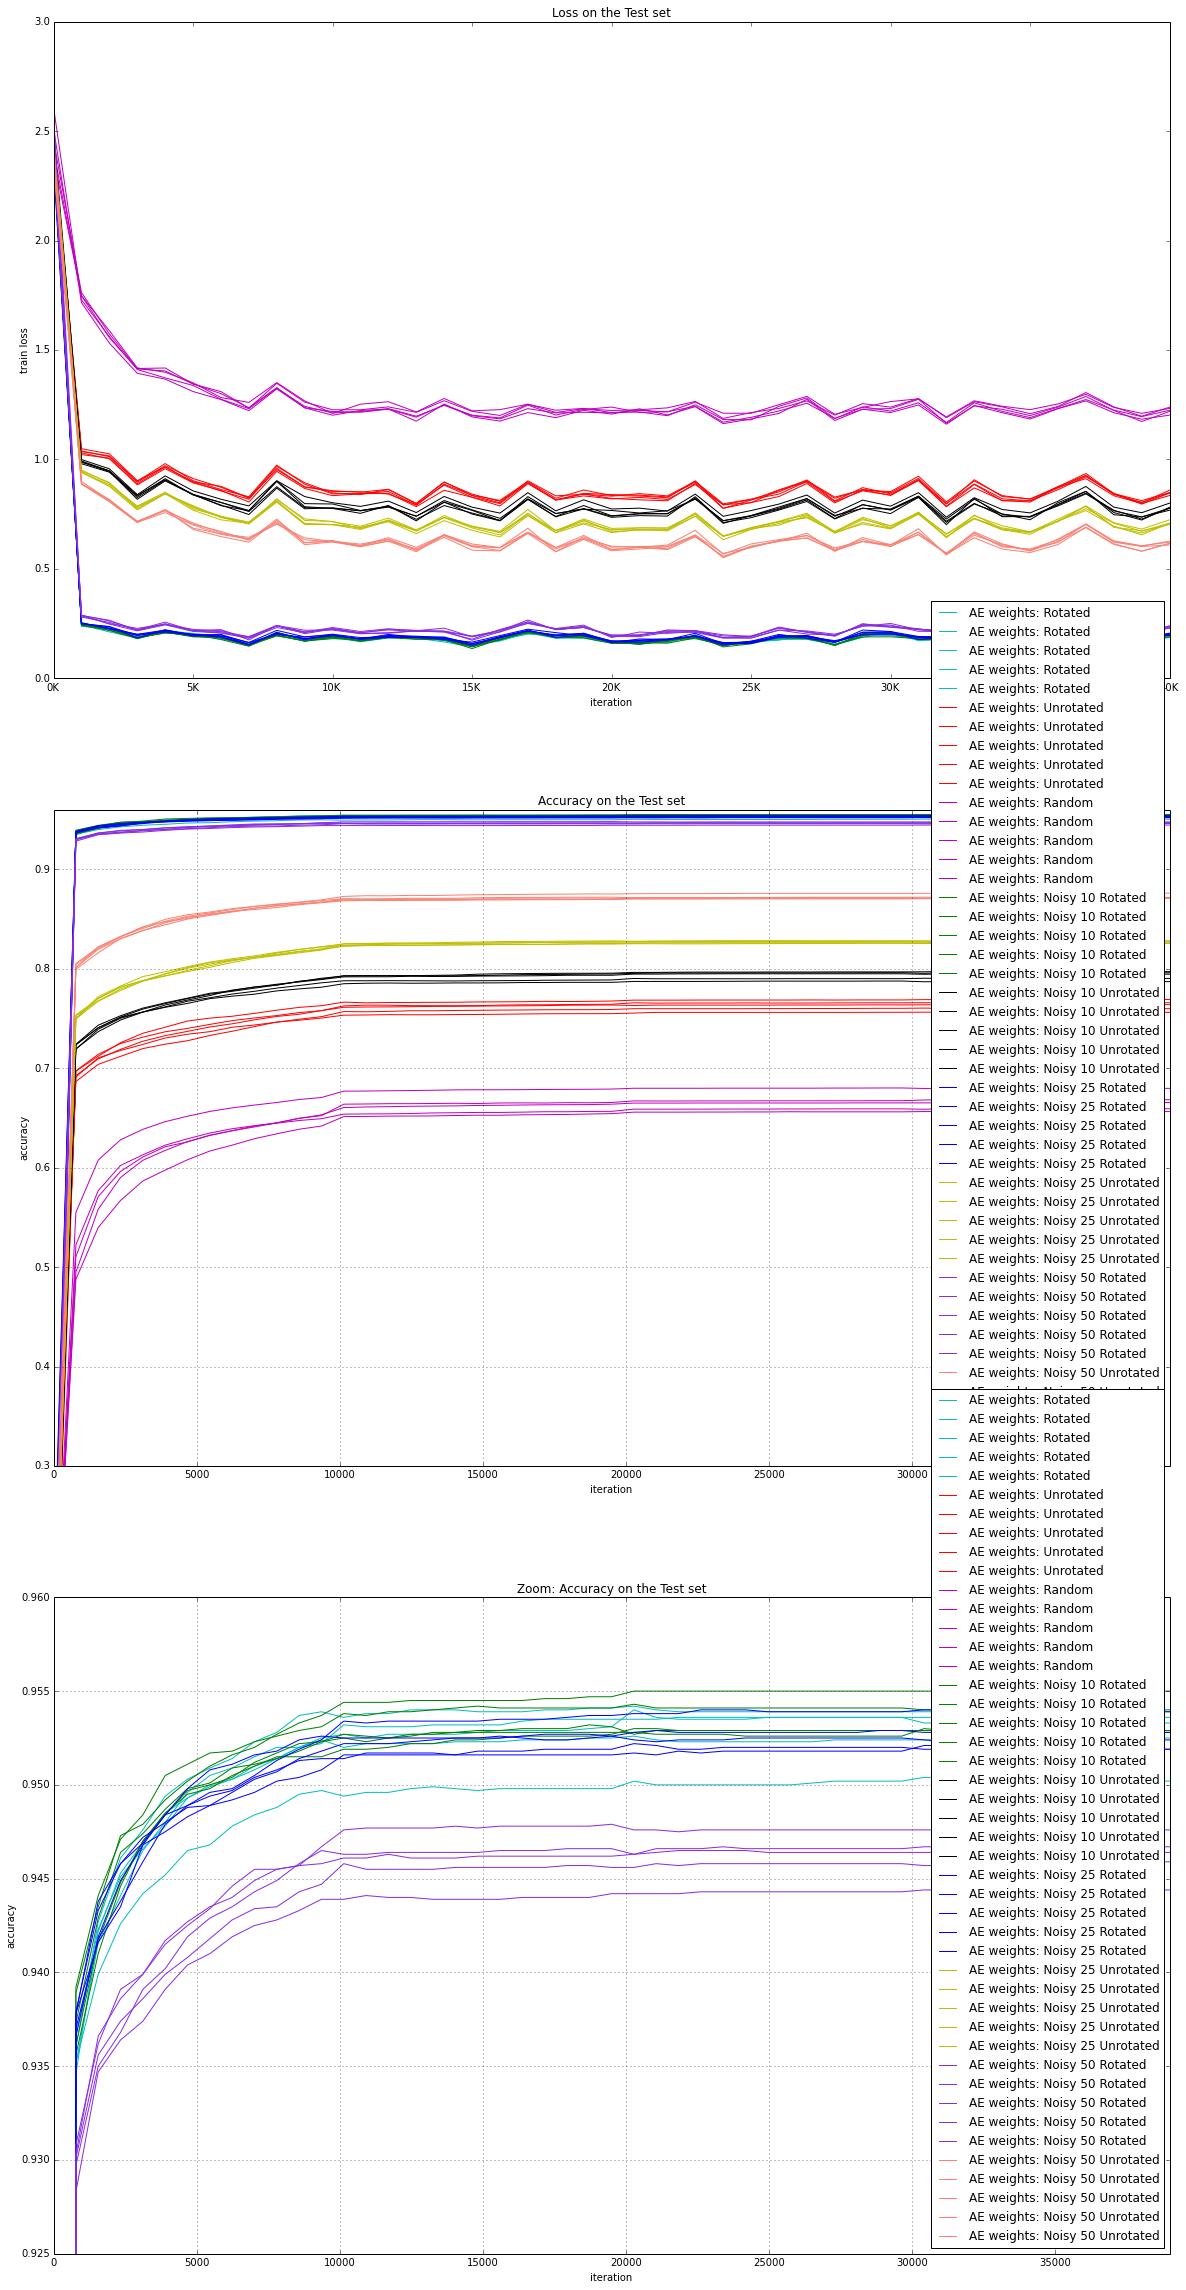

In [10]:
color = [ 'c', 'r', 'm','g', 'k','b', 'y', '#8A2BE2', '#fa8174']
fig = plt.figure(figsize=(20,40))
xmax = 39000
ymin = 0.7
ymax = 0.96
fix_date = '0609'
num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
for i,e in enumerate(exps):
    for j in range(len(dates_list)):

        plt.subplot(3,1,1)
        ma = np.mean(loss[i], axis = 0).squeeze()
        mstd = np.std(loss[i], axis = 0).squeeze()
        num_iter = exp_data[fix_date]['AER'][Phase.TRAIN]['num_iter']
        plt.plot(num_iter, loss[i][j], label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=color[i])
        #plt.fill_between(num_iter.squeeze(), ma-2*mstd, ma+2*mstd, color=color[i], alpha=0.2)
        plt.xlim(0,xmax)
        plt.xlabel('iteration')
        # format x-axis ticks
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
        plt.ylabel('train loss')
        plt.title("Loss on the %s set" % (phase,))


        ymin = 0.3
        ymax = 0.96
        plt.subplot(3,1,2)
        num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
        ma = np.mean(acc[i][j], axis = 0).squeeze()
        mstd = np.std(acc[i][j], axis = 0).squeeze()
        plt.plot(num_iter, acc[i][j], label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=color[i])
        #plt.fill_between(num_iter.squeeze(), ma-2*mstd, ma+2*mstd, color=color[i], alpha=0.2)
        plt.xlim(0,xmax)
        plt.ylim(ymin,ymax)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.title("Accuracy on the %s set" % (phase,))
        plt.legend(loc='lower right')
        plt.grid()


        ymin = 0.925
        ymax = 0.96
        plt.subplot(3,1,3)
        num_iter = exp_data[fix_date]['AER'][Phase.TEST]['num_iter']
        ma = np.mean(acc[i][j], axis = 0).squeeze()
        mstd = np.std(acc[i], axis = 0).squeeze()
        plt.plot(num_iter, acc[i][j], label='AE weights: %s' % (exp_data[fix_date][e]['label'],), color=color[i])
        #plt.fill_between(num_iter.squeeze(), ma-2*mstd, ma+2*mstd, color=color[i], alpha=0.2)
        plt.xlim(0,xmax)
        plt.ylim(ymin,ymax)
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.title("Zoom: Accuracy on the %s set" % (phase,))
        plt.legend(loc='lower right')
        plt.grid()

plt.show()

## Hypothesis Testing

In [7]:
from scipy.stats import ttest_rel as ttest
acc_last = {e:[] for e in exps}


for d,_ in exp_data.items():
    for i,e in enumerate(exps):
        acc_last[e].append(exp_data[d][e][Phase.TEST]['acc'][-1])

# AENR10 vs AER
_, p_1 = ttest(acc_last['AENR10'],acc_last['AER'])
# AENR10 vs AENR25
_, p_2 = ttest(acc_last['AENR10'],acc_last['AENR25'])
# AER vs AER25
_, p_3 = ttest(acc_last['AER'],acc_last['AENR25'])

# AER vs AEUR
_, p_4 = ttest(acc_last['AER'],acc_last['AEUR'])

In [8]:
print(p_1, p_2, p_3, p_4)

(array([ 0.25414092]), array([ 0.1707423]), array([ 0.85132651]), array([  1.19828524e-07]))


In [23]:
print('Difference Rotated vs. Rotated + 10% Noise: {}%'.format((np.mean(acc_last['AENR10'])  - np.mean(acc_last['AER']))*100))

Difference Rotated vs. Rotated + 10% Noise: 0.084%
